In [15]:
%pip install Pillow pytz

In [16]:
from PIL import Image, ExifTags
import os

directory_path = '/content'
image_metadata = {}

# Create reverse lookup for tag names
tag_map = {v: k for k, v in ExifTags.TAGS.items()}

for filename in os.listdir(directory_path):
    if filename.lower().endswith(('.jpg', '.jpeg')):
        file_path = os.path.join(directory_path, filename)
        try:
            with Image.open(file_path) as img:
                exif_data = img.getexif()
                if not exif_data:
                    print(f"No EXIF found in {filename}")
                    continue

                # Try the common datetime tags
                datetime = None
                for tag_name in ("DateTimeOriginal", "DateTimeDigitized", "DateTime"):
                    tag_id = tag_map.get(tag_name)
                    if tag_id in exif_data:
                        datetime = exif_data.get(tag_id)
                        break

                if datetime:
                    image_metadata[filename] = datetime
                else:
                    print(f"No datetime tag found in {filename}")

        except Exception as e:
            print(f"Could not process {filename}: {e}")

print("\nExtracted DateTime info:")
print(image_metadata)



Extracted DateTime info:
{'DSCF8258.JPG': '2025:10:18 18:20:10', 'DSCF7780.JPG': '2025:10:17 18:03:58', 'DSCF8259.JPG': '2025:10:18 18:20:14'}


# Task
Draw a red circle around each star in the .JPG images in "/content". Display the new images with the circles drawn around them.

## Load the images

### Subtask:
Load the .JPG images from the specified directory.


**Reasoning**:
Load the .JPG images from the specified directory into a dictionary.



In [17]:
image_objects = {}
directory_path = '/content'

for filename in os.listdir(directory_path):
    if filename.lower().endswith(('.jpg', '.jpeg')):
        file_path = os.path.join(directory_path, filename)
        try:
            img = Image.open(file_path)
            image_objects[filename] = img
        except Exception as e:
            print(f"Could not open {filename}: {e}")

print(f"Loaded {len(image_objects)} images.")

Loaded 3 images.


## Preprocess images

### Subtask:
Convert images to grayscale, and potentially apply noise reduction techniques to enhance star detection.


**Reasoning**:
Iterate through the loaded images, convert them to grayscale, apply a median filter for noise reduction, and store the preprocessed images.



In [18]:
from PIL import Image, ImageFilter

preprocessed_images = {}

for filename, img in image_objects.items():
    # Convert to grayscale
    grayscale_img = img.convert("L")

    # Apply median filter for noise reduction
    # A kernel size of 3 or 5 is often suitable for initial noise reduction
    denoised_img = grayscale_img.filter(ImageFilter.MedianFilter(size=3))

    preprocessed_images[filename] = denoised_img

print("Finished preprocessing images (grayscale and noise reduction).")

Finished preprocessing images (grayscale and noise reduction).


## Detect potential stars

### Subtask:
Use image processing algorithms to identify potential star-like objects in the images. This might involve thresholding, contour detection, or feature detection methods.


**Reasoning**:
Implement image processing steps to identify potential star-like objects using thresholding and contour detection.



In [19]:
import cv2
import numpy as np

detected_stars = {}

for filename, img in preprocessed_images.items():
    # Convert PIL image to numpy array for OpenCV
    img_np = np.array(img)

    # Apply Otsu's thresholding to get a binary image
    # Otsu's method automatically determines the optimal threshold value
    # for separating foreground (stars) from background.
    _, binary_img = cv2.threshold(img_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours in the binary image
    # cv2.findContours can return different outputs depending on the OpenCV version.
    # The code handles both possibilities.
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Store the detected contours
    detected_stars[filename] = contours

print("Finished detecting potential stars using thresholding and contour finding.")

Finished detecting potential stars using thresholding and contour finding.


## Filter and refine star candidates

### Subtask:
Apply criteria to filter out non-star objects based on characteristics like size, shape, and intensity.


**Reasoning**:
Iterate through the detected contours for each image, calculate properties like area, aspect ratio, and circularity, and filter out contours that don't meet defined criteria for being stars. Store the filtered contours in a new dictionary.



In [20]:
import cv2
import numpy as np

refined_stars = {}

for filename, contours in detected_stars.items():
    image_refined_stars = []
    for contour in contours:
        # Calculate area
        area = cv2.contourArea(contour)

        # Calculate aspect ratio
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h if h > 0 else 0

        # Calculate circularity (approximation)
        # Perimeter is needed for circularity. Use arcLength.
        perimeter = cv2.arcLength(contour, True)
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        # Define criteria for stars (these thresholds might need adjustment)
        # Example criteria:
        # - Area is not too large (to exclude large objects)
        # - Area is not too small (to exclude noise)
        # - Aspect ratio is close to 1 (for somewhat circular shapes)
        # - Circularity is relatively high (closer to 1 for perfect circle)
        # - Consider adding intensity check if possible (need original image data)

        # Example thresholds - these are illustrative and may need tuning
        min_area = 20  # Increased minimum area
        max_area = 300 # Adjusted maximum area
        min_aspect_ratio = 0.7 # Narrowed aspect ratio range
        max_aspect_ratio = 1.5 # Narrowed aspect ratio range
        min_circularity = 0.7 # Increased minimum circularity

        # Apply criteria
        if (area > min_area and area < max_area and
            aspect_ratio > min_aspect_ratio and aspect_ratio < max_aspect_ratio and
            circularity > min_circularity):
            image_refined_stars.append(contour)

    refined_stars[filename] = image_refined_stars

print("Finished refining potential stars based on shape and size criteria.")
print(f"Number of refined stars per image: {[len(stars) for stars in refined_stars.values()]}")

Finished refining potential stars based on shape and size criteria.
Number of refined stars per image: [32, 22, 30]


## Draw circles

### Subtask:
Draw red circles around the detected stars on the original images.


**Reasoning**:
Draw red circles around the refined star contours on the original images and store the modified images.



In [21]:
import cv2
import numpy as np

images_with_stars = {}

for filename, contours in refined_stars.items():
    # Load the original image using PIL and convert to BGR for OpenCV
    img_pil = image_objects[filename]
    img_np = np.array(img_pil.convert('RGB'))
    img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    # Iterate through the refined contours and draw circles
    for contour in contours:
        # Calculate the bounding circle
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)

        # Draw the circle
        cv2.circle(img_cv, center, radius, (0, 0, 255), 2) # Red color (0, 0, 255) and thickness 2

    # Store the modified image (convert back to PIL if needed, or keep as numpy array)
    # For this task, we'll store the OpenCV (numpy) array
    images_with_stars[filename] = img_cv

print("Finished drawing circles around refined stars.")

Finished drawing circles around refined stars.


**Reasoning**:
Display the images with the drawn circles.



In [22]:
from IPython.display import display
from PIL import Image

print("Displaying images with stars circled:")
for filename, img_cv in images_with_stars.items():
    # Convert OpenCV BGR image (numpy array) back to PIL RGB image for display
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)

    print(f"\n{filename}:")
    display(img_pil)

Output hidden; open in https://colab.research.google.com to view.

Loaded 3 images.
Finished preprocessing images (grayscale + mild blur).
DSCF8258.JPG: 1 raw contours detected


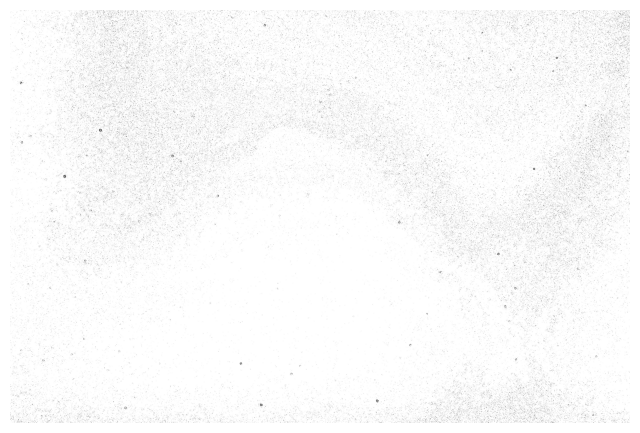

DSCF7780.JPG: 6 raw contours detected


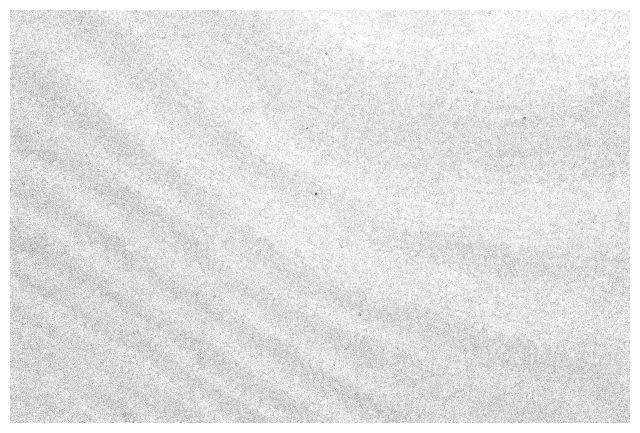

DSCF8259.JPG: 1 raw contours detected


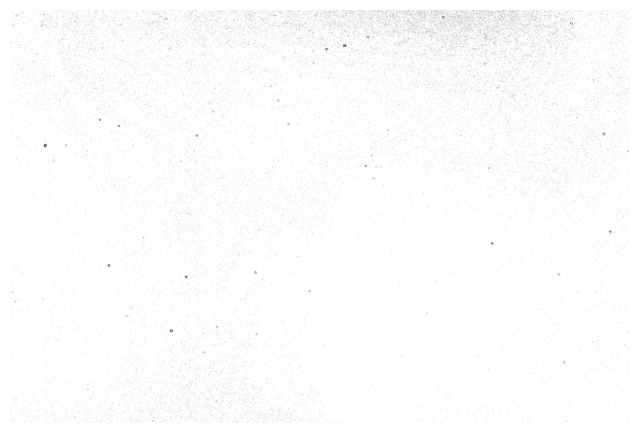

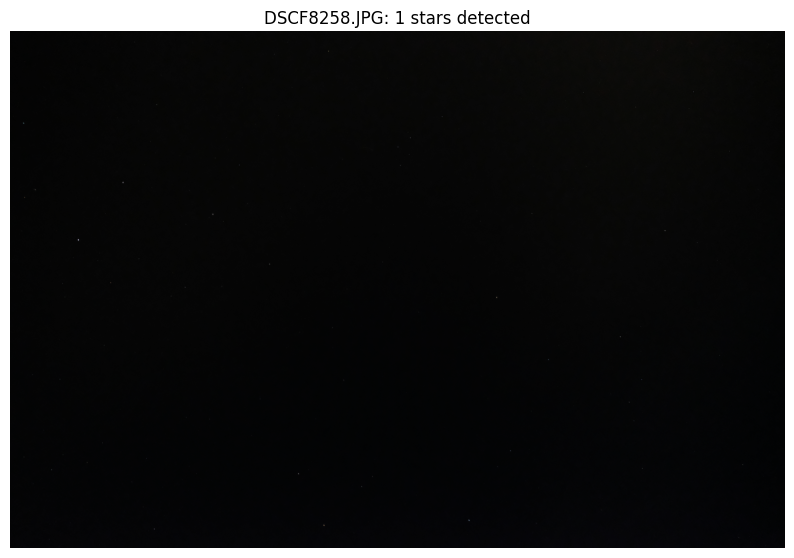

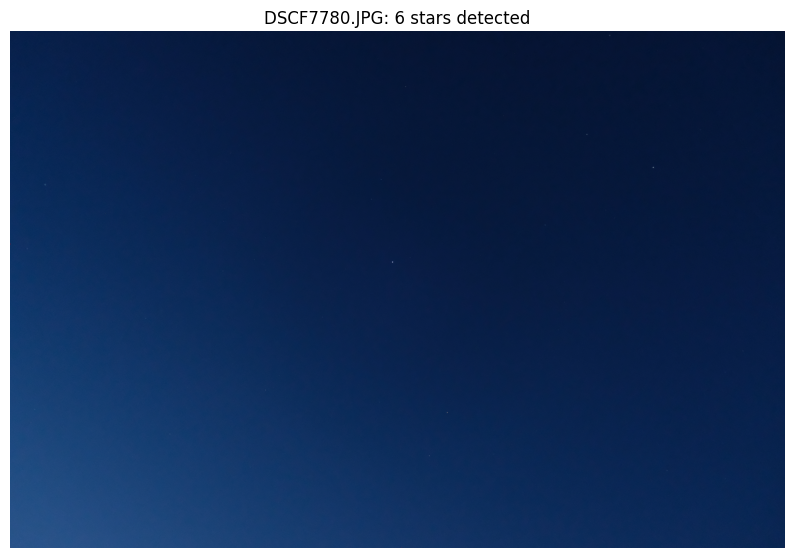

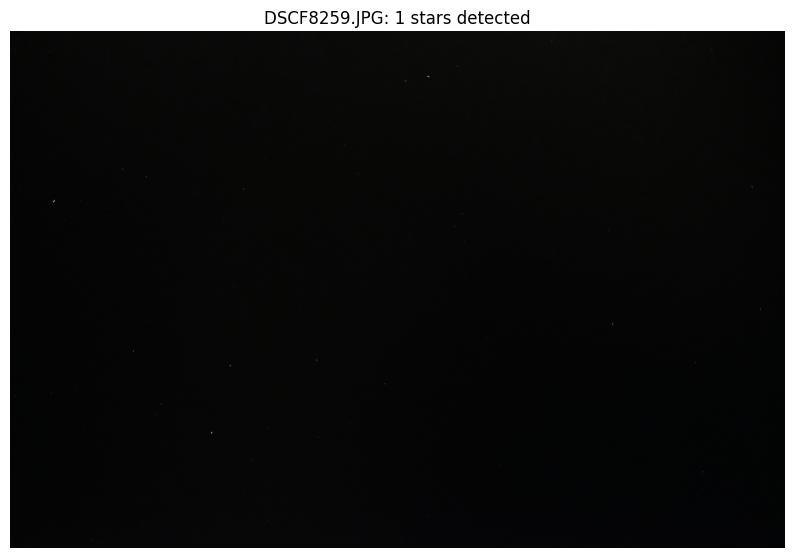

Finished drawing circles around detected stars.


In [28]:
import os
import cv2
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

# ==============================
# 1. Load images
# ==============================
image_objects = {}
directory_path = '/content'  # change to your folder path

for filename in os.listdir(directory_path):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        file_path = os.path.join(directory_path, filename)
        try:
            img = Image.open(file_path)
            image_objects[filename] = img
        except Exception as e:
            print(f"Could not open {filename}: {e}")

print(f"Loaded {len(image_objects)} images.")

# ==============================
# 2. Preprocess images
# ==============================
preprocessed_images = {}

for filename, img in image_objects.items():
    # Convert to grayscale
    grayscale_img = img.convert("L")

    # Slight Gaussian blur (keeps faint stars better than median filter)
    blurred_img = grayscale_img.filter(ImageFilter.GaussianBlur(radius=1))

    preprocessed_images[filename] = blurred_img

print("Finished preprocessing images (grayscale + mild blur).")

detected_stars = {}

for filename, img in preprocessed_images.items():
    img_np = np.array(img)

    # Normalize brightness
    img_np = cv2.normalize(img_np, None, 0, 255, cv2.NORM_MINMAX)

    # Mild Gaussian blur
    blurred = cv2.GaussianBlur(img_np, (3, 3), 0)

    # CLAHE contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)

    # Adaptive threshold (moderate sensitivity)
    binary_img = cv2.adaptiveThreshold(
        enhanced,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        25,  # medium block size
        5    # moderate C value
    )

    # Morphological cleanup: only remove isolated noise pixels
    kernel = np.ones((2, 2), np.uint8)
    binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    detected_stars[filename] = contours

    print(f"{filename}: {len(contours)} raw contours detected")

    # Quick visual check
    plt.figure(figsize=(8, 8))
    plt.imshow(binary_img, cmap='gray')
    plt.axis('off')
    plt.show()

# ==============================
# 5. Draw circles around stars
# ==============================
images_with_stars = {}

for filename, contours in detected_stars.items():
    img_pil = image_objects[filename]
    img_np = np.array(img_pil.convert('RGB'))
    img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(img_cv, center, radius, (0, 0, 255), 1)  # red circle

    images_with_stars[filename] = img_cv

    # Show final result
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.title(f"{filename}: {len(contours)} stars detected")
    plt.axis('off')
    plt.show()

print("Finished drawing circles around detected stars.")
